In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..")))
from tools import plot, utils, nn_modules
from tools.nn_modules import GammaToneFilterbank, FIRFilter1D
import numpy as np

import IPython.display as ipd

2.0.1


Let's inspect our building blocks, starting with the gammatone filterbank implementation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


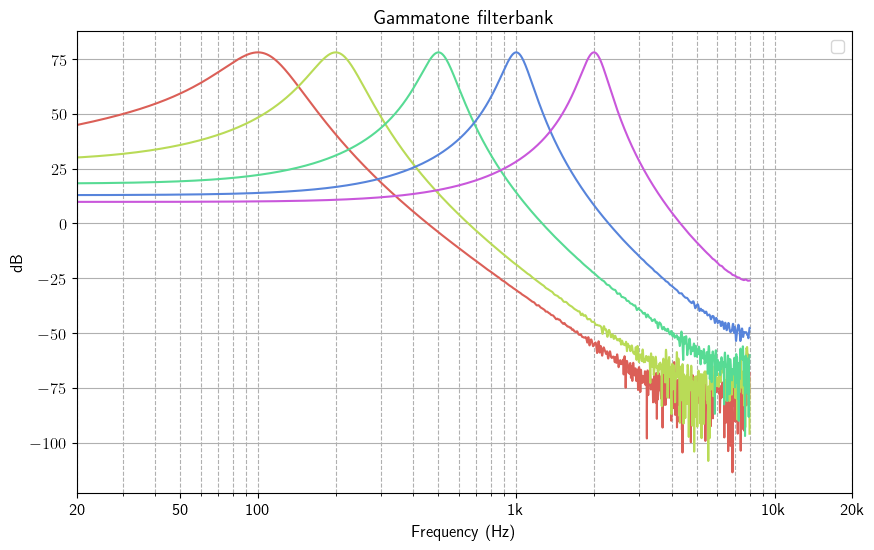

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


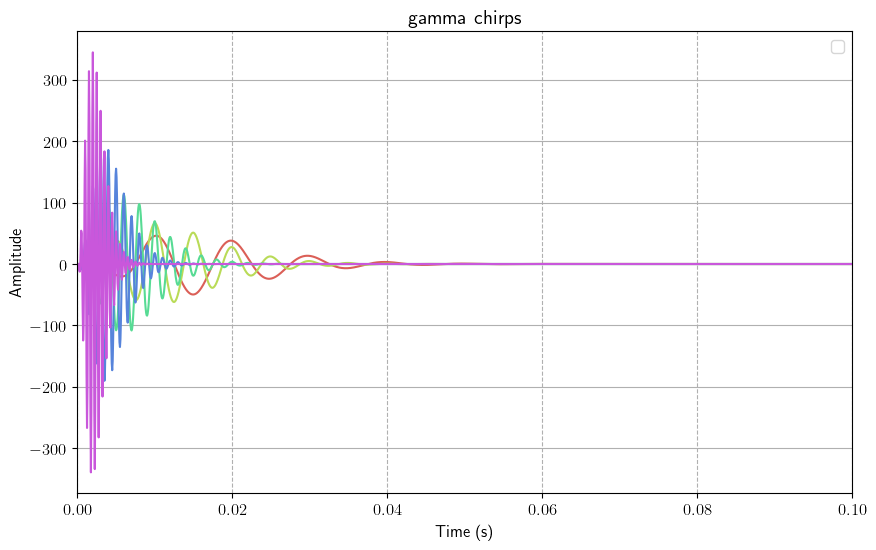

In [19]:
sample_rate = 16000
filterbank = GammaToneFilterbank(
    duration=1,
    center_frequencies=[100, 200, 500, 1000, 2000],
    fs_hz=sample_rate,
    impairment_factor=0,
)

freq_axes = []
spec_axes = []
time_signals = []
for filter in filterbank.filters:
    h, f = utils.get_spectrum(filter.impulse_response, sample_rate=sample_rate)
    freq_axes.append(f)
    spec_axes.append(h)
    time_signals.append(filter.impulse_response)

# Plot IR in time-domain and magnitude repsonse
plot.magspec(freq_axes=freq_axes, spec_axes=spec_axes, title="Gammatone filterbank")
plot.timeseries(
    time_signals, sample_rate=sample_rate, xlim=[0, 0.1], title="gamma chirps"
)

Create Normal hearing model

In [20]:
from tools.nn_modules import FIRFilter1D, FIRFilter1DLinearPhaseI, GammaToneFilterbank


class NormalModel(nn.Module):
    """My model"""
    def __init__(self, sample_rate, center_frequencies):
        super(NormalModel, self).__init__()
        self.samplerate = sample_rate
        self.center_frequencies = center_frequencies
        self.duration = .25 # fixed

        self.gamma_bank = GammaToneFilterbank(
            self.duration,self.center_frequencies, self.samplerate
        )

    def forward(self, x):
        signals = self.gamma_bank(x)
        out = torch.zeros_like(signals[0])
        for signal in signals:
            out += signal # Sum outputs of filterbank
        return torch.div(out,torch.max(torch.abs(out)))

Try feeding it with dummy data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


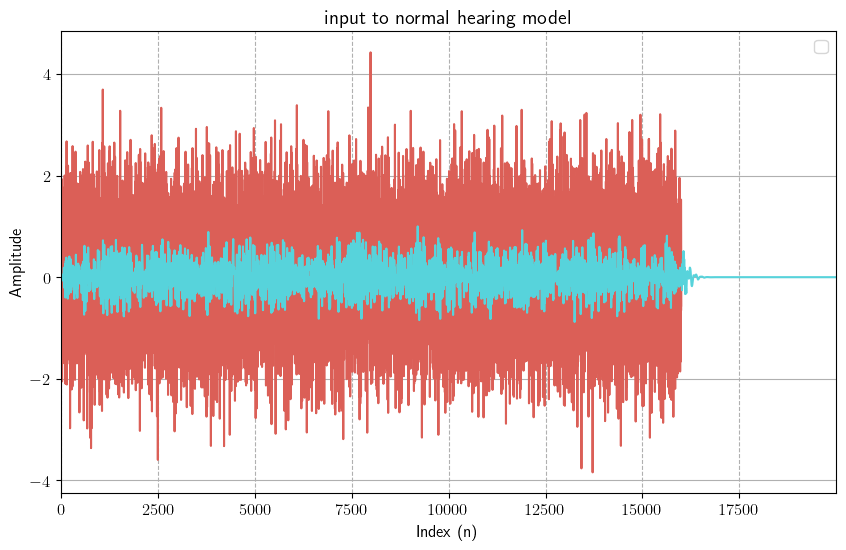

In [21]:
def batch_2_np(batch):
    return batch[0][0].detach().numpy()

sample_rate = 16_000
center_frequencies = [100, 200, 500, 1000]

# Dummy training data
# Random input data and target labels
n_batch = 1
n_samples = 16_000
n_channels = 1

x = torch.randn(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
# input_data[:, :, 0] = 1.0  # Impulse
normal_model = NormalModel(sample_rate=sample_rate,center_frequencies=center_frequencies)
out = normal_model(x)

plot.timeseries([batch_2_np(x), batch_2_np(out)], 
                title="input to normal hearing model")

# plot.timeseries([batch_2_np(out)], 
#                 title="output of normal hearing model")


In [22]:
ipd.Audio(batch_2_np(x), rate=sample_rate) # load a NumPy array

In [23]:
ipd.Audio(np.flip(batch_2_np(out)), rate=sample_rate) # load a NumPy array

In [24]:
from tools.nn_modules import FIRFilter1D, GammaToneFilterbank


class ImpairedModel(nn.Module):
    """My model"""

    def __init__(self, num_taps, samplerate, center_frequencies, impairment_factor=1.0):
        super(ImpairedModel, self).__init__()
        self.num_taps = num_taps
        self.samplerate = samplerate
        self.center_frequencies = center_frequencies
        self.impairent_factor = impairment_factor
        self.duration = .25 # fixed at 1

        self.gamma_bank = GammaToneFilterbank(
            self.duration, self.center_frequencies, self.samplerate, self.impairent_factor
        )

        self.gain = FIRFilter1D(self.num_taps)

    def forward(self, x):
        x = self.gain(x)
        signals = self.gamma_bank(x)
        out = torch.zeros_like(signals[0])
        for signal in signals:
            out += signal # Sum outputs of filterbank
        # Normalize
        return torch.div(out,torch.max(torch.abs(out)))

Let's pass dummy data into the model

torch.Size([1, 1, 5048])


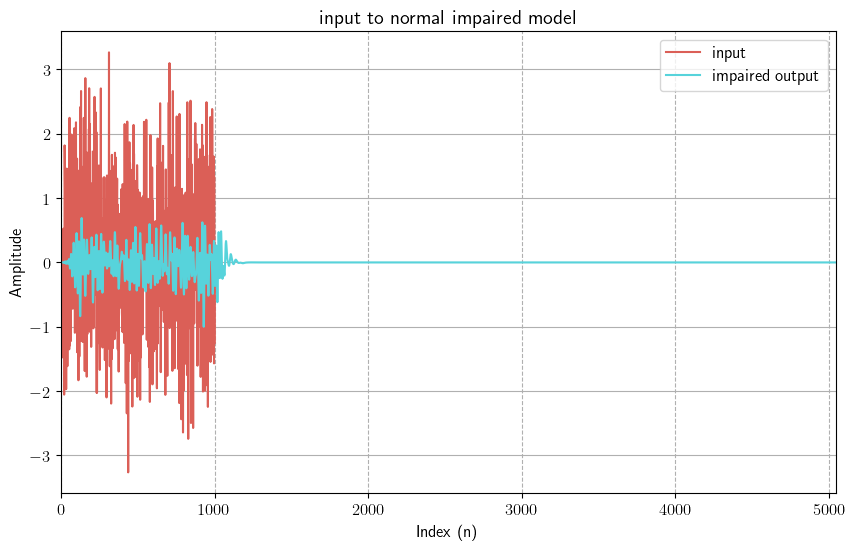

In [25]:
sample_rate = 16_000
center_frequencies = [100, 200, 500, 1000]

# Dummy training data
# Random input data and target labels
n_batch = 1
n_samples = 1000
n_channels = 1

x = torch.randn(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
# input_data[:, :, 0] = 1.0  # Impulse
impaired_model = ImpairedModel(
    num_taps=50,
    samplerate=sample_rate, 
    center_frequencies=center_frequencies,
    impairment_factor=100,
)

out = impaired_model(x)
print(out.shape)
plot.timeseries([batch_2_np(x), batch_2_np(out)], 
                title="Impaired model input-output",
                labels=['input', 'impaired output'])


In [26]:
# ipd.Audio(batch_2_np(x), rate=sample_rate) # load a NumPy array
ipd.Audio(np.flip(batch_2_np(out)), rate=sample_rate) # load a NumPy array

Create Whole model 

In [27]:
import torch.optim as optim


class MyModel(nn.Module):
    """My model"""

    def __init__(self, num_taps, samplerate, center_frequencies, impairment_factor=1.0):
        super(MyModel, self).__init__()
        self.num_taps = num_taps
        self.samplerate = samplerate
        self.center_frequencies = center_frequencies
        self.impairent_factor = impairment_factor
        self.duration = .25  # fixed at 1

        self.normal_model = NormalModel(
            sample_rate=sample_rate, 
            center_frequencies=self.center_frequencies
        )

        self.impaired_model = ImpairedModel(
            num_taps=self.num_taps,
            samplerate=self.samplerate,
            center_frequencies=self.center_frequencies,
            impairment_factor=self.impairent_factor,
        )

    def forward(self, x):
        out_HI = self.impaired_model(x)
        out_NH = self.normal_model(x)
        # Zero pad normal hearing to match HI
        out_NH = F.pad(input = out_NH,pad=[0,self.num_taps-1],mode='constant',value=0)
        return out_NH, out_HI

In [28]:
sample_rate = 16_000
center_frequencies = [100, 200, 500, 1000]

# Dummy training data
# Random input data and target labels
n_batch = 1
n_samples = 1000
n_channels = 1

x = torch.randn(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
# input_data[:, :, 0] = 1.0  # Impulse

model = MyModel(
    num_taps=100,
    samplerate=sample_rate, 
    center_frequencies=center_frequencies,
    impairment_factor=1000,
)

out_NH, out_HI = model(x)

print(model)

MyModel(
  (normal_model): NormalModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0-3): 4 x GammaToneFilter()
      )
    )
  )
  (impaired_model): ImpairedModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0-3): 4 x GammaToneFilter()
      )
    )
    (gain): FIRFilter1D()
  )
)


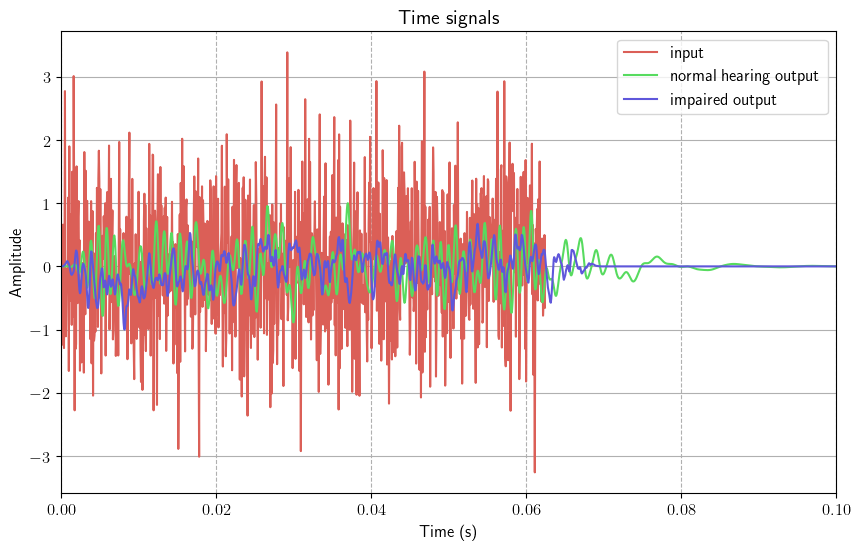

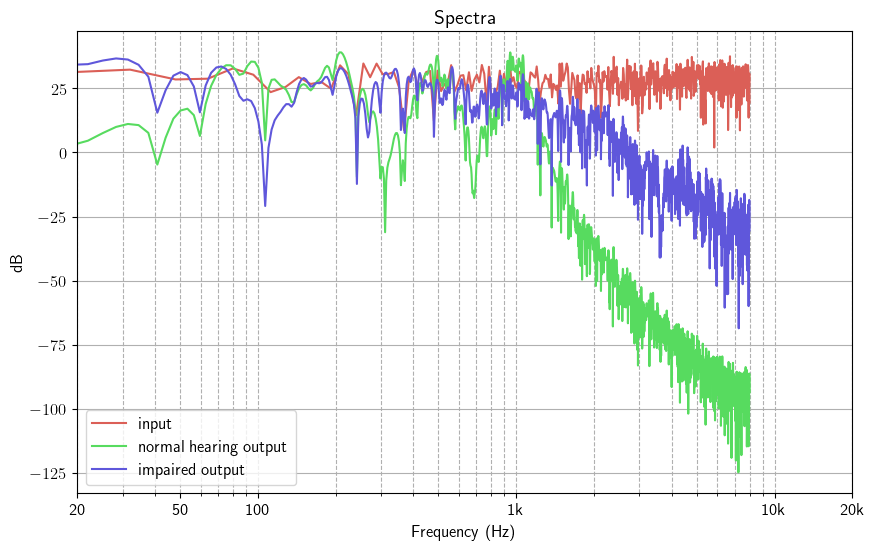

In [29]:
freq_axes = []
spec_axes = []
time_signals = []

for filter in [batch_2_np(x), batch_2_np(out_NH), batch_2_np(out_HI)]:
    h, f = utils.get_spectrum(filter, sample_rate=sample_rate)
    freq_axes.append(f)
    spec_axes.append(h)
    time_signals.append(filter)

# Plot IR in time-domain and magnitude repsonse
plot.timeseries(
    time_signals, sample_rate=sample_rate, xlim=[0, 0.1], title="Input-output signals",
    labels=['input','normal hearing output', 'impaired output']
)
plot.magspec(freq_axes=freq_axes, spec_axes=spec_axes, title="Spectra",
                 labels=['input','normal hearing output', 'impaired output']
)

In [30]:
import torch.optim as optim
from torchmetrics import ScaleInvariantSignalDistortionRatio
# Dummy training data
# Random input data and target labels
n_batch = 100
n_samples = 1000
n_channels = 1

input_data = torch.zeros(n_batch, n_channels, n_samples)
input_data[:,:,0] = 1.0  # impulse at 0

# Loss function and optimizer
criterion = ScaleInvariantSignalDistortionRatio()
# criterion = nn.
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Dummy training loop
num_epochs = 1000
for epoch in range(num_epochs):
    total_loss = 0.0

    # Forward pass and compute loss
    out_NH, out_HI = model(input_data)
    loss = -criterion(out_HI,out_NH)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

# Optionally, you can save the trained model
# torch.save(model.state_dict(), 'fir_filter.pth')

Epoch 1/100, Loss: 23.373859405517578
Epoch 2/100, Loss: 21.893449783325195
Epoch 3/100, Loss: 20.832414627075195
Epoch 4/100, Loss: 20.000967025756836
Epoch 5/100, Loss: 19.315752029418945
Epoch 6/100, Loss: 18.73221778869629
Epoch 7/100, Loss: 18.223642349243164
Epoch 8/100, Loss: 17.772663116455078
Epoch 9/100, Loss: 17.367361068725586
Epoch 10/100, Loss: 16.999183654785156
Epoch 11/100, Loss: 16.661787033081055
Epoch 12/100, Loss: 16.350322723388672
Epoch 13/100, Loss: 16.061010360717773
Epoch 14/100, Loss: 15.790840148925781
Epoch 15/100, Loss: 15.537374496459961
Epoch 16/100, Loss: 15.298620223999023
Epoch 17/100, Loss: 15.072916030883789
Epoch 18/100, Loss: 14.858867645263672
Epoch 19/100, Loss: 14.655294418334961
Epoch 20/100, Loss: 14.461182594299316
Epoch 21/100, Loss: 14.27566909790039
Epoch 22/100, Loss: 14.097983360290527
Epoch 23/100, Loss: 13.927478790283203
Epoch 24/100, Loss: 13.763566970825195
Epoch 25/100, Loss: 13.605731964111328
Epoch 26/100, Loss: 13.4535226821899

torch.Size([1, 1, 5098]) torch.Size([1, 1, 5098])


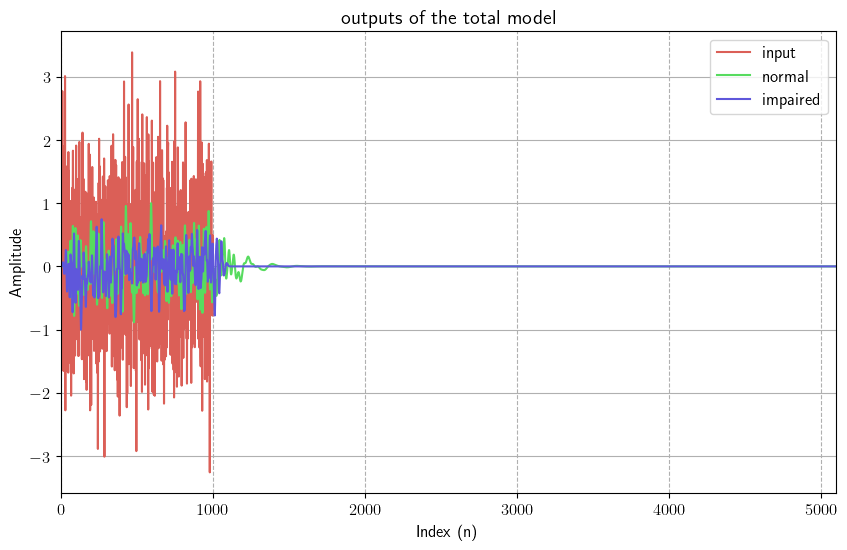

In [31]:
out_NH, out_HI = model(x)
print(out_NH.shape, out_HI.shape)
plot.timeseries([batch_2_np(x), batch_2_np(out_NH), batch_2_np(out_HI)], 
                title="outputs of the total model",
                labels=['input','normal','impaired'])

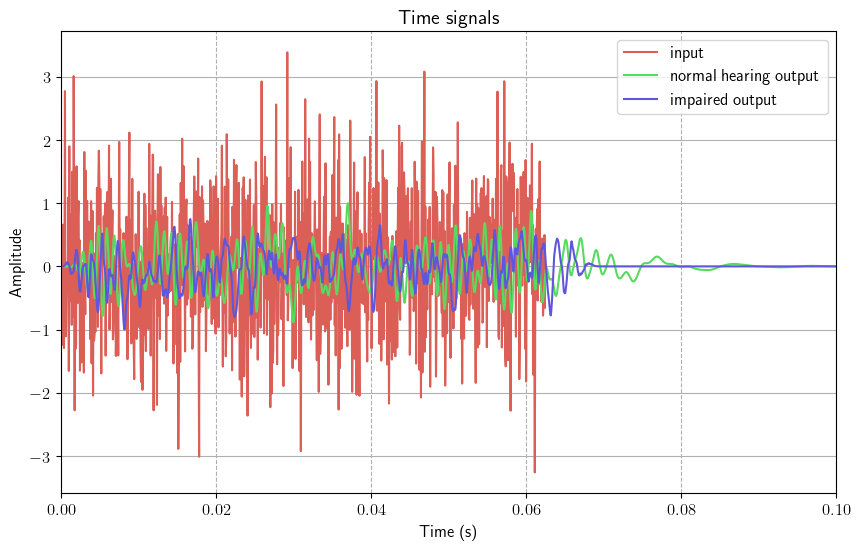

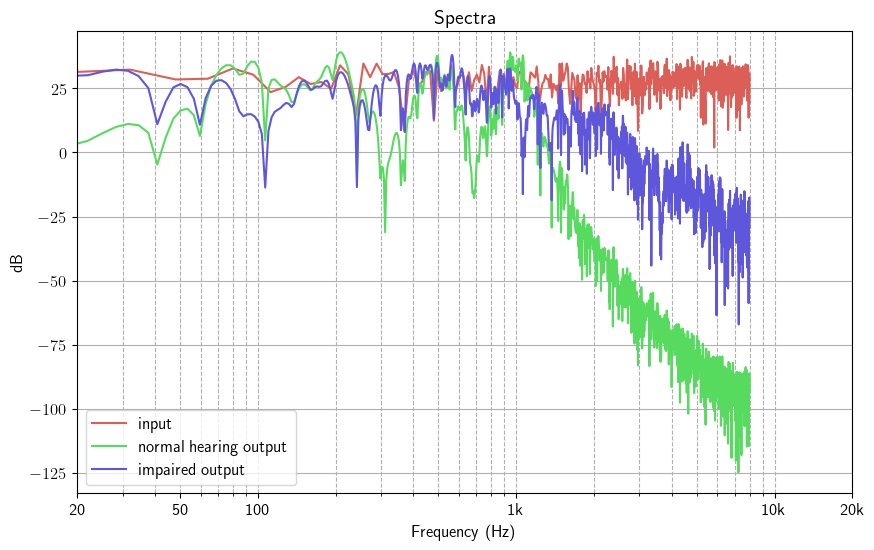

In [32]:
freq_axes = []
spec_axes = []
time_signals = []

for filter in [batch_2_np(x), batch_2_np(out_NH), batch_2_np(out_HI)]:
    h, f = utils.get_spectrum(filter, sample_rate=sample_rate)
    freq_axes.append(f)
    spec_axes.append(h)
    time_signals.append(filter)

# Plot IR in time-domain and magnitude repsonse
plot.timeseries(
    time_signals, sample_rate=sample_rate, xlim=[0, 0.1], title="Time signals",
    labels=['input','normal hearing output', 'impaired output']
)
plot.magspec(freq_axes=freq_axes, spec_axes=spec_axes, title="Spectra",
                 labels=['input','normal hearing output', 'impaired output']
)

In [33]:
for sample in [batch_2_np(x), batch_2_np(out_NH), batch_2_np(out_HI)]:
    ipd.Audio(sample, rate=sample_rate) # load a NumPy array

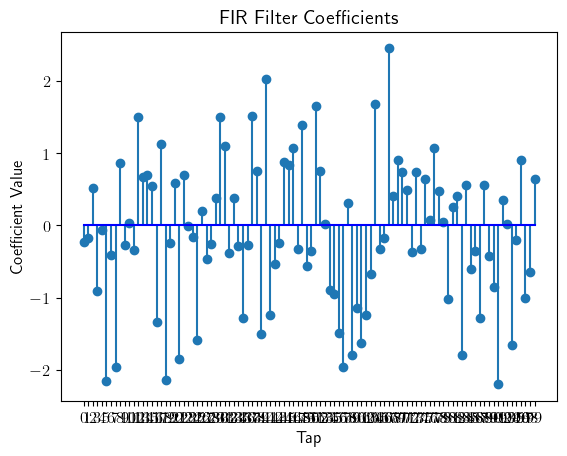

In [34]:
coeffs = model.impaired_model.gain.filter_taps.detach().numpy()
plot.filter_coeffs(coeffs)

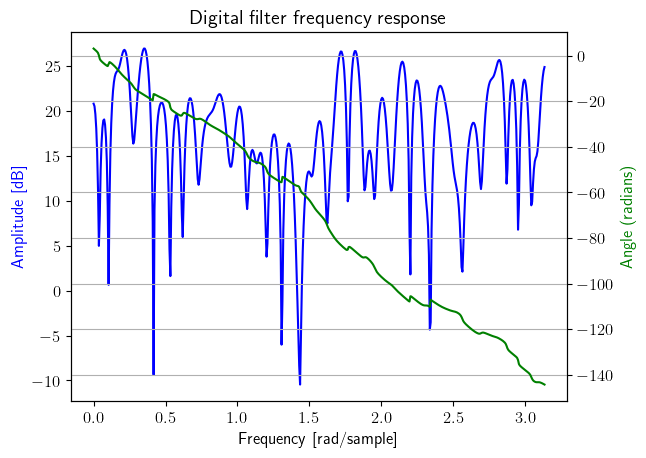

NameError: name 'pi' is not defined

In [35]:
from scipy import signal
w, h = signal.freqz(coeffs)
plot.bode_digital(w,h)
plot.magspec([w/(2*pi)*sample_rate],[h])